# 208Tl preprod 

* Check the efficiency of 208Tl simulation

In [1]:
import pandas as pd
import tables as tb
import glob
import numpy as np
from invisible_cities.io.dst_io import load_dst
import matplotlib.pyplot as plt


In [2]:
nexus_path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/{isotope}/prod/{port}/nexus/*.h5'

In [3]:
# NUMBER OF SIMULATED EVENTS
nevent_per_file = 10000
nfiles_per_port = 300
nevents_per_port = nevent_per_file * nfiles_per_port
nport = 4
nevents = nevents_per_port * nport

In [4]:
nevents

12000000

## 208Tl nexus info @5 bar

In [5]:
def get_mc_info(f, active = True):
    hit_df = load_dst(f, 'MC', 'hits')
    conf_df = load_dst(f, 'MC', 'configuration')
    if active: hit_df = hit_df[hit_df.label == 'ACTIVE']
    hit_df = hit_df.merge(hit_df.groupby('event_id').energy.sum().rename('tot_ene'), on='event_id')
    hit_df = hit_df.merge(hit_df.groupby('event_id').size().rename('nhits'), on='event_id')
    hit_df_ = hit_df[['event_id', 'tot_ene', 'nhits']].drop_duplicates()

    hit_df_['port'] = conf_df[conf_df.param_key == '/Generator/IonGenerator/region'].param_value.values[0].replace(' ', '')
    # hit_df_['sim_evs'] = int(conf_df[conf_df.param_key == 'num_events'].param_value.values[0])
    # hit_df_['sav_evs'] = int(conf_df[conf_df.param_key == 'saved_events'].param_value.values[0])
    # hit_df_['file_id'] = int(f.split('/')[-1].split('_')[1])
    return hit_df_

In [6]:
def get_part_recursive(part_df, out_gammas, all_out_gammas_part = pd.DataFrame()):
    if all_out_gammas_part.empty:
        out_gammas_part = out_gammas[['event_id', 'mother_id']].merge(part_df[['event_id', 'mother_id', 'particle_id', 'particle_name', 'initial_volume']], on = ['event_id', 'mother_id']).rename(columns = {'mother_id':'gamma_mother_id'})
        all_out_gammas_part = all_out_gammas_part.append(out_gammas_part)
    else:
        out_gammas_part = out_gammas.copy()
    next_out_gammas_part = out_gammas_part[['event_id', 'gamma_mother_id', 'particle_id']].rename(\
                                                                            columns = {'particle_id':'mother_id'}).merge(\
                                                                                                                        part_df[['event_id', 'mother_id', 'particle_id', 'particle_name', 'initial_volume']], on = ['event_id', 'mother_id']).drop(columns = 'mother_id')
    all_out_gammas_part = all_out_gammas_part.append(next_out_gammas_part)
    if not next_out_gammas_part.empty:
        get_part_recursive(part_df, next_out_gammas_part, all_out_gammas_part)

    all_out_gammas_part = out_gammas.rename(columns = {'mother_id':'gamma_mother_id'}).merge(all_out_gammas_part, on = ['event_id', 'gamma_mother_id'])
    return all_out_gammas_part

In [7]:
def get_gamma_products(file):
    port_name = file.split('/')[-3]
    hit_df = load_dst(file, 'MC', 'hits')
    part_df = load_dst(file, 'MC', 'particles')

    hit_df = hit_df[hit_df.label == 'ACTIVE']

    hit_part_ener = hit_df.groupby(['event_id', 'particle_id']).energy.sum().reset_index().rename(columns = {'energy':'hit_energy'})

    #here we change particle_id to mother_id to merge with the particles df and find the sons of the selected gammas; the other values are changed to identify they come from the gammas
    out_gammas = part_df[(part_df.particle_name == 'gamma') & (part_df.creator_proc == 'RadioactiveDecay')][['event_id', 'particle_id','final_volume', 'kin_energy', 'final_proc']].rename(columns = {'particle_id':'mother_id', 'kin_energy':'kin_gamma_energy', 'final_volume':'final_gamma_volume', 'final_proc':'final_gamma_proc'})

    all_out_gammas_part = get_part_recursive(part_df, out_gammas)

    final_out_gammas_part = all_out_gammas_part.merge(hit_part_ener, on = ['event_id', 'particle_id']).groupby(['event_id', 'gamma_mother_id', 'final_gamma_volume', 'kin_gamma_energy', 'final_gamma_proc']).sum().reset_index().drop(columns = 'particle_id')
    final_out_gammas_part['port'] = port_name
    return final_out_gammas_part

In [8]:
# info_df_208Tl = pd.DataFrame()
# for f in sorted(glob.glob(nexus_path.format(isotope='208Tl', port='*')), key = lambda x: (x.split('/')[-3], int(x.split('_')[-2]))):
#     info_df_208Tl = info_df_208Tl.append(get_mc_info(f))

In [9]:
# gamma_part_df = pd.DataFrame()
# for f in sorted(glob.glob(nexus_path.format(isotope='208Tl', port='*')), key = lambda x: (x.split('/')[-3], int(x.split('_')[-2]))):
#     gamma_part_df = gamma_part_df.append(get_gamma_products(f))

In [10]:
sim_evs_info = pd.DataFrame([{'sim_evs_per_file': nevent_per_file, 'sim_files_per_port': nfiles_per_port, 'n_ports':nport}])

In [11]:
save_path_208Tl = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/summary_208Tl.h4'
# info_df_208Tl.to_hdf(save_path_208Tl, key = 'events_info') 
# sim_evs_info.to_hdf(save_path_208Tl, key = 'sim_info') 

In [12]:
save_path_gammas_208Tl = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/summary_gammas_208Tl.h4'
# gamma_part_df.to_hdf(save_path_gammas_208Tl, key = 'gammas_info') 

In [13]:
info_df_208Tl = pd.read_hdf(save_path_208Tl, 'events_info')
sim_evs_info = pd.read_hdf(save_path_208Tl, 'sim_info')
gamma_part_df = pd.read_hdf(save_path_gammas_208Tl, 'gammas_info')

In [14]:

size_path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/size_data.txt'
with open(size_path, 'r') as f:
        text = f.readlines()
        f.close()
folder_size = [[t.split("\t")[1].split('/')[2].rstrip('\n'),float(t.split("\t")[0].rstrip('G').replace(',', '.'))] for t in text[:-1]]
size_df = pd.DataFrame(folder_size, columns = ['port', 'size'])

In [15]:
size_df

,port,size
0,,16.0
1,,16.0
2,,15.0
3,,16.0


In [16]:
def print_effs_and_sim(df, isotope, size_df, e_threshold = (0, np.inf), nevents_per_port = nevents_per_port, nevents = nevents, desired_events = 1e6, round_factor = 1e5, target_evs_file = 2e4):
    df = df[(df.tot_ene > e_threshold[0]) & (df.tot_ene < e_threshold[1])]
    size_df = size_df.set_index('port')['size']
    port_eff = df.groupby('port').size() / nevents_per_port

    print('MC efficiencies ({} < E < {})'.format(e_threshold[0], e_threshold[1]))
    print('Each port:')
    print(port_eff)
    print('')

    print('Total efficiency')
    print(len(df) / nevents)

    print('')
    print('In each port we will need to simulate (to have at least 1M events):')
    print(desired_events / port_eff)

    print('')
    print('Which we can set up to:')
    target_evs_port = np.ceil((desired_events / port_eff).max() / round_factor) * round_factor
    print(target_evs_port, ' events per port')
    print(target_evs_port / target_evs_file, ' tasks/files per port if we simulate ', target_evs_file, ' events per file')
    print('With the current eff, these files will have around ', target_evs_file * port_eff.mean(), ' events per file')
    print('')
    print('For having 1M, we expect that the production will occupy:')
    expected_size = size_df / df.groupby('port').size() * desired_events
    print(expected_size)
    print('In total: {} G'.format(expected_size.sum()))
    return port_eff, expected_size

In [17]:
#_, _ = print_effs_and_sim(info_df_208Tl, '208Tl', size_df)

In [18]:
#port_eff_208Tl, exp_size_208Tl = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=(0.4, np.inf))

In [19]:
#_, _ = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=(1.45, 1.75))

Esta eff coincide aprox con la que tenía Gonzalo para ese rango de energía (0.007), yo quizás tengo menos estadística

#### Vamos a plotear un esquema del cilindro con las eff para cada puerto

In [20]:
sim_evs_info

,sim_evs_per_file,sim_files_per_port,n_ports
0,10000,300,4


In [21]:
info_df_208Tl.count()

event_id    367404
tot_ene     367404
nhits       367404
port        367404
dtype: int64

In [22]:
# Cylinder surface parameters
radius = 67.555
zmin = -84
zmax = +84
resolution = 200  # Number of points to approximate the cylinder's surface

def cylinder_surface(rad, zmin, zmax, resol):
    # Create points for the cylinder's surface
    theta = np.linspace(0, 2 * np.pi, resol)
    z = np.linspace(zmin, zmax, resol)
    Theta, Z = np.meshgrid(theta, z)
    X = rad * np.cos(Theta)
    Y = rad * np.sin(Theta)
    return X, Y, Z

# Ports of the cylinder
port_x = (47.77, 47.477, -47.77, -47.77)
port_y = (47.77, 47.477,  47.77,  47.77)
port_z = (-13.95, 45.05, -30.79, 19.21)
port_n = ('PORT_1a', 'PORT_2a', 'PORT_1b', 'PORT_2b')
port_info = [port_x, port_y, port_z, port_n]

# Eff for each port in a energy range
e_range = (0.4, np.inf)
port_eff_208Tl, exp_size_208Tl = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=e_range)

MC efficiencies (0.4 < E < inf)
Each port:
port
PORT_1a    0.033872
PORT_1b    0.032640
PORT_2a    0.023862
PORT_2b    0.032094
dtype: float64

Total efficiency
0.030617

In each port we will need to simulate (to have at least 1M events):
port
PORT_1a    2.952291e+07
PORT_1b    3.063725e+07
PORT_2a    4.190822e+07
PORT_2b    3.115815e+07
dtype: float64

Which we can set up to:
42000000.0  events per port
2100.0  tasks/files per port if we simulate  20000.0  events per file
With the current eff, these files will have around  612.34  events per file

For having 1M, we expect that the production will occupy:
port
          NaN
          NaN
          NaN
          NaN
PORT_1a   NaN
PORT_1b   NaN
PORT_2a   NaN
PORT_2b   NaN
dtype: float64
In total: 0.0 G


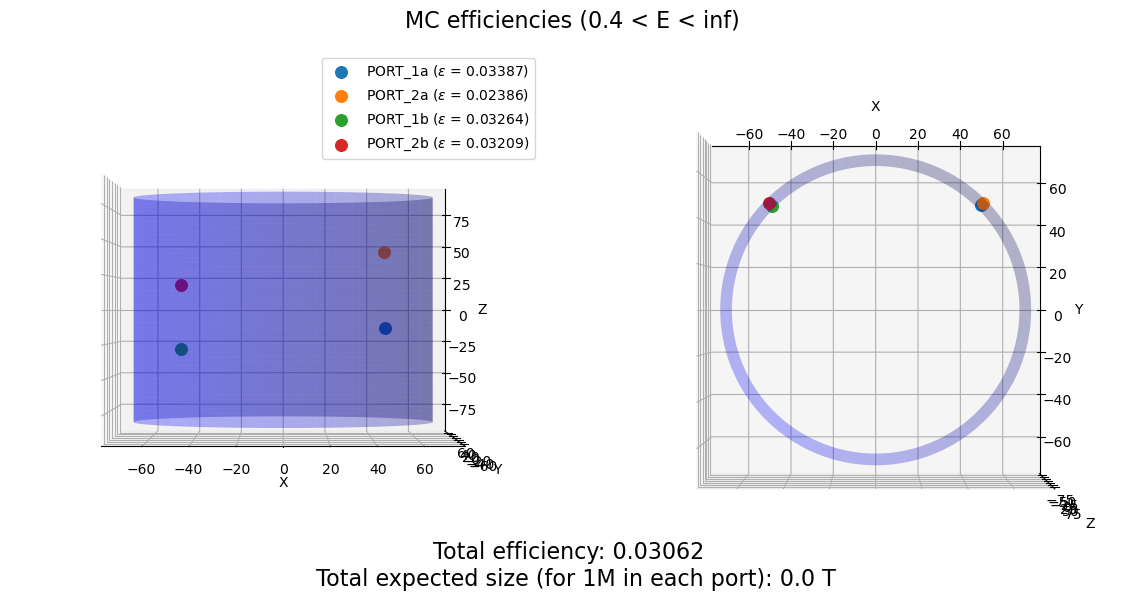

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize = (12, 6))

cyl_surf = cylinder_surface(radius, zmin, zmax, resolution)

def plot_next100_scheme(fig, subplot, cyl_surf, port_info, port_eff, ang = (0, 0)):
    # Create a 3D figure
    
    ax = fig.add_subplot(subplot, projection='3d')

    # Plot the surface of the cylinder
    X, Y, Z = cyl_surf[0], cyl_surf[1], cyl_surf[2]
    ax.plot_surface(X, Y, Z, color='b', alpha= 0.3)

    # Plot the ports of the cylinder
    port_x, port_y, port_z, port_n = port_info
    ax.scatter(port_x[0], port_y[0], port_z[0], marker='o', s=70, label=port_n[0] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[0]]))
    ax.scatter(port_x[1], port_y[1], port_z[1], marker='o', s=70, label=port_n[1] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[1]]))
    ax.scatter(port_x[2], port_y[2], port_z[2], marker='o', s=70, label=port_n[2] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[2]]))
    ax.scatter(port_x[3], port_y[3], port_z[3], marker='o', s=70, label=port_n[3] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[3]]))

    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=ang[0], azim=ang[1]) 
    return ax

plt.suptitle('MC efficiencies ({} < E < {})'.format(e_range[0], e_range[1]), fontsize=16)
fig.text(0.5, 0.02, 'Total efficiency: {:.4} \n Total expected size (for 1M in each port): {:.3} T'.format(port_eff_208Tl.mean(), exp_size_208Tl.sum() / 1000), ha='center', fontsize=16)
ax = plot_next100_scheme(fig, 121, cyl_surf, port_info, port_eff_208Tl, ang=(0, -90))
ax.legend()
ax = plot_next100_scheme(fig, 122, cyl_surf, port_info, port_eff_208Tl, ang=(90, 270))
plt.tight_layout()

# Show the plot
plt.show()


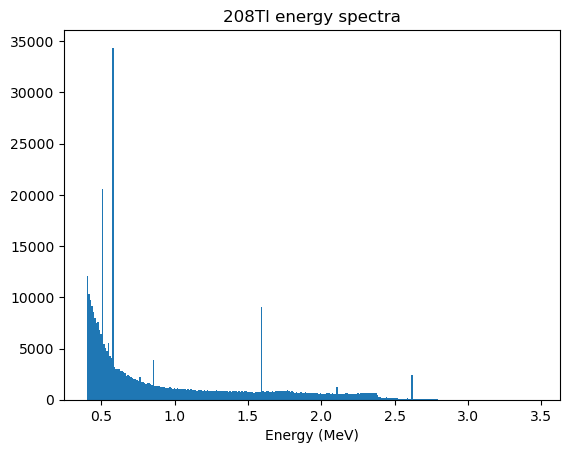

In [20]:
plt.hist(info_df_208Tl.tot_ene, 300)
plt.title('208Tl energy spectra')
plt.xlabel('Energy (MeV)')
plt.show()

## 208Tl sophronia info @5 bar

In [6]:
path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/{isotope}/prod/{port}/prod/{city}/*.h5'

In [25]:
city = 'sophronia'

# sophronia_info = pd.DataFrame()
# for f in sorted(glob.glob(path.format(isotope = '208Tl', port='*', city = city)), key = lambda x: (x.split('/')[-4], int(x.split('_')[-2]))):
#     soph_df = load_dst(f, 'RECO', 'Events')
#     soph_df = soph_df.groupby('event').Ec.sum().reset_index().rename(columns = {'Ec':'total_Ec'})
#     soph_df['port'] = f.split('/')[-4]
    
#     sophronia_info = sophronia_info.append(soph_df)

# sophronia_info.to_hdf('/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration_5bar/208Tl/prod/{city}_summary_208Tl.h4'.format(city = 'soph'), key = 'summary')   

In [26]:
#sophronia_info = pd.read_hdf('/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration_5bar/208Tl/prod/{city}_summary_208Tl.h4'.format(city = 'soph'), 'summary')  

## 208Tl isaura info @5 bar

In [8]:
def get_pao_info(f):
    pao_sum = load_dst(f, 'Summary', 'Events')
    pao_trk = load_dst(f, 'Tracking', 'Tracks')

    pao_sum = pao_sum[['event', 'evt_energy', 'evt_ntrks', 'evt_nhits']]
    pao_trk = pao_trk[['event', 'trackID', 'energy', 'length', 'numb_of_tracks', 'numb_of_voxels', 'numb_of_hits', 'eblob1', 'eblob2', 'ovlp_blob_energy']]

    pao_sum['port'] = f.split('/')[-4]
    pao_trk['port'] = f.split('/')[-4]
    
    return pao_sum, pao_trk

In [9]:
def write_pao_summary(path, city, save_path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/prod/{city}_summary_208Tl.h4'):

    paolina_summary, paolina_tracks = pd.DataFrame(), pd.DataFrame()

    for f in sorted(glob.glob(path.format(isotope = '208Tl', port='*', city = city)), key = lambda x: (x.split('/')[-4], int(x.split('_')[-2]))):
        sum_, trk_ = get_pao_info(f)
        paolina_summary = paolina_summary.append(sum_)
        paolina_tracks = paolina_tracks.append(trk_)
    paolina_summary.to_hdf(save_path.format(city = city), key = 'summary') 
    paolina_tracks.to_hdf(save_path.format(city = city), key = 'tracks') 

In [10]:
save_path_paolina = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/prod/{city}_summary_10mm_208Tl.h4'

path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/{isotope}/prod/{port}/prod/old_beersh_prod/{city}/*.h5'

# write_pao_summary(path, 'esmeralda', save_path = save_path_paolina)
write_pao_summary(path, 'isaura', save_path = save_path_paolina)

In [30]:
isaura_summary = pd.read_hdf(save_path_paolina.format(city = 'isaura'), 'summary')
isaura_tracks = pd.read_hdf(save_path_paolina.format(city = 'isaura'), 'tracks')

esmeralda_summary = pd.read_hdf(save_path_paolina.format(city = 'esmeralda'), 'summary')
esmeralda_tracks = pd.read_hdf(save_path_paolina.format(city = 'esmeralda'), 'tracks')

We will take info of the full event, and then only for the main tracks of each event

For the full event, looking to the summary table, we will plot energy, number of tracks and number of hits

In [31]:
isaura_summary

,event,evt_energy,evt_ntrks,evt_nhits,port
0,0,0.498971,2,5504,PORT_1a
1,2,2.142774,8,9230,PORT_1a
2,4,1.350785,3,9290,PORT_1a
3,6,0.307136,2,2424,PORT_1a
4,8,1.104626,2,6527,PORT_1a
...,...,...,...,...,...
289,5980588,1.881291,8,8266,PORT_2b
290,5980590,2.052916,6,7128,PORT_2b
291,5980592,0.366655,4,2351,PORT_2b
292,5980594,1.067402,2,6907,PORT_2b


In [32]:
esmeralda_summary

,event,evt_energy,evt_ntrks,evt_nhits,port
0,0,0.407661,1,11,PORT_1a
1,2,2.142774,3,38,PORT_1a
2,4,1.345012,2,98,PORT_1a
3,8,0.920186,1,7,PORT_1a
4,10,0.274068,1,8,PORT_1a
...,...,...,...,...,...
230,5980588,1.761294,2,13,PORT_2b
231,5980590,2.052916,2,30,PORT_2b
232,5980592,0.366655,1,1,PORT_2b
233,5980594,0.613080,1,6,PORT_2b


In [33]:
isaura_summary[isaura_summary.evt_energy > 0.4]

,event,evt_energy,evt_ntrks,evt_nhits,port
0,0,0.498971,2,5504,PORT_1a
1,2,2.142774,8,9230,PORT_1a
2,4,1.350785,3,9290,PORT_1a
4,8,1.104626,2,6527,PORT_1a
5,10,0.401522,2,4557,PORT_1a
...,...,...,...,...,...
288,5980586,0.417062,4,3365,PORT_2b
289,5980588,1.881291,8,8266,PORT_2b
290,5980590,2.052916,6,7128,PORT_2b
292,5980594,1.067402,2,6907,PORT_2b


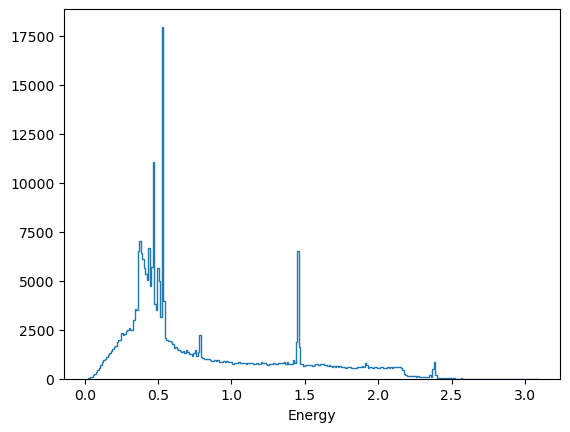

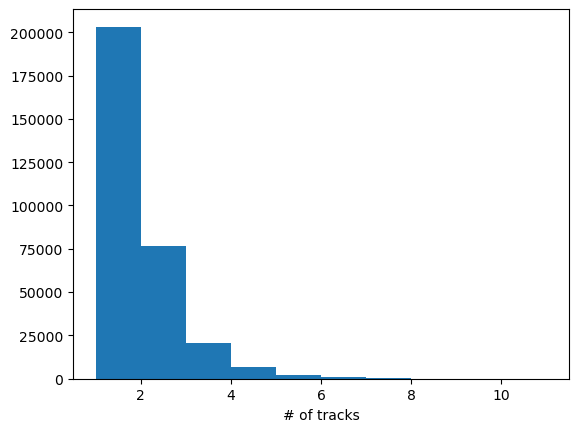

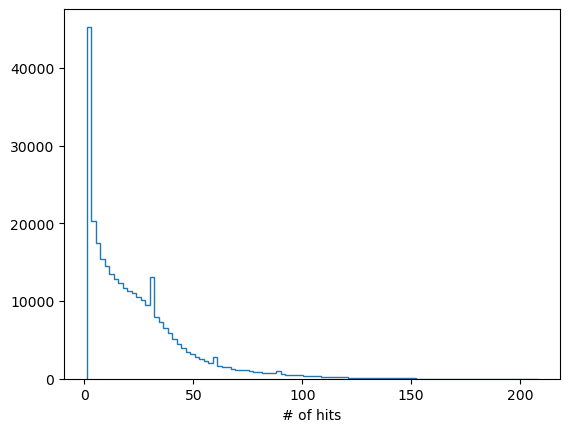

In [35]:

plt.hist(esmeralda_summary.evt_energy, 300, histtype='step')
plt.xlabel('Energy')
plt.show()

plt.hist(esmeralda_summary.evt_ntrks, esmeralda_summary.evt_ntrks.max(), range = (esmeralda_summary.evt_ntrks.min(), esmeralda_summary.evt_ntrks.max() + 1))
plt.xlabel('# of tracks')
plt.show()

plt.hist(esmeralda_summary.evt_nhits, 100, histtype='step')
plt.xlabel('# of hits')
plt.show()

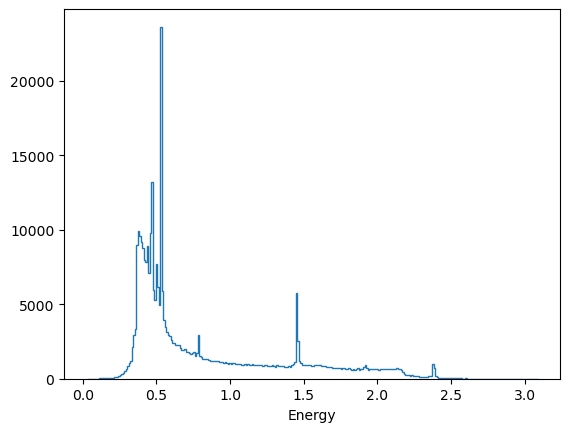

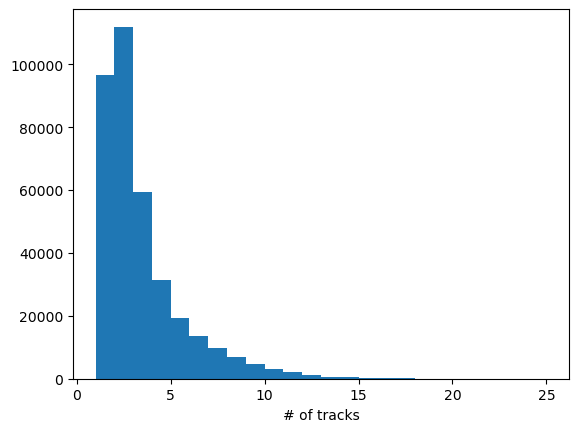

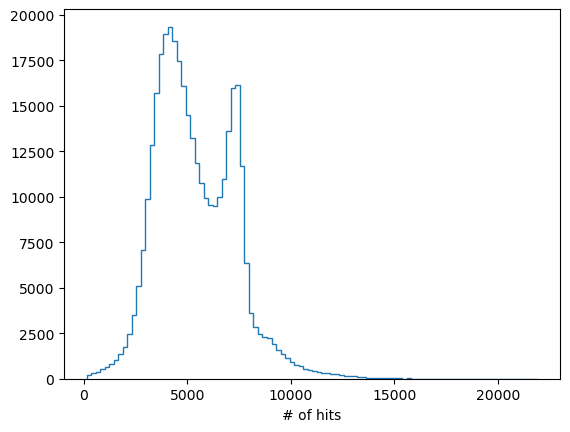

In [36]:

plt.hist(isaura_summary.evt_energy, 300, histtype='step')
plt.xlabel('Energy')
plt.show()

plt.hist(isaura_summary.evt_ntrks, isaura_summary.evt_ntrks.max(), range = (isaura_summary.evt_ntrks.min(), isaura_summary.evt_ntrks.max() + 1))
plt.xlabel('# of tracks')
plt.show()

plt.hist(isaura_summary.evt_nhits, 100, histtype='step')
plt.xlabel('# of hits')
plt.show()

For the main track, we will plot energy, length, (nvoxels, nhits), eblob1, eblob2, (ovlp) + positions?? Not really

In [155]:
isaura_tracks

,event,energy,length,numb_of_tracks,numb_of_voxels,numb_of_hits,eblob1,eblob2,ovlp_blob_energy,port
0,0,0.382997,42.430003,2,34,4755,0.201220,0.180495,0.018180,PORT_1a
1,0,0.085802,19.473684,2,4,533,0.083881,0.081491,0.079570,PORT_1a
2,2,1.236384,75.567095,8,69,4806,0.682325,0.084547,0.000000,PORT_1a
3,2,0.291442,110.356891,8,41,1281,0.049249,0.044542,0.000000,PORT_1a
4,2,0.170599,90.262922,8,36,591,0.064402,0.054091,0.000000,PORT_1a
...,...,...,...,...,...,...,...,...,...,...
786,5980594,0.646187,35.855058,2,39,5263,0.520242,0.320726,0.202087,PORT_2b
787,5980594,0.151644,14.690775,2,8,1166,0.151644,0.151644,0.151644,PORT_2b
788,5980596,0.812594,55.379976,3,75,5572,0.480316,0.226159,0.000000,PORT_2b
789,5980596,0.039528,10.643915,3,3,113,0.039528,0.039528,0.039528,PORT_2b


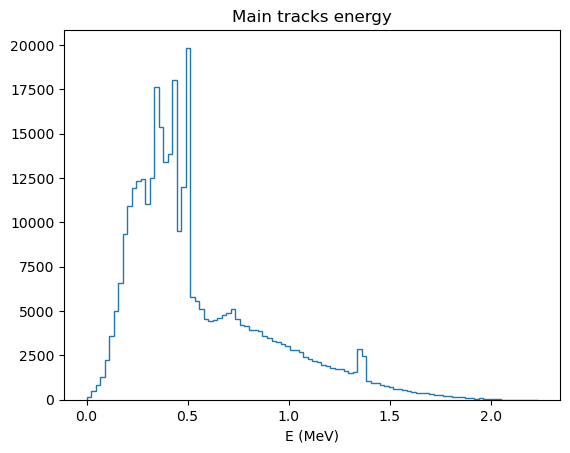

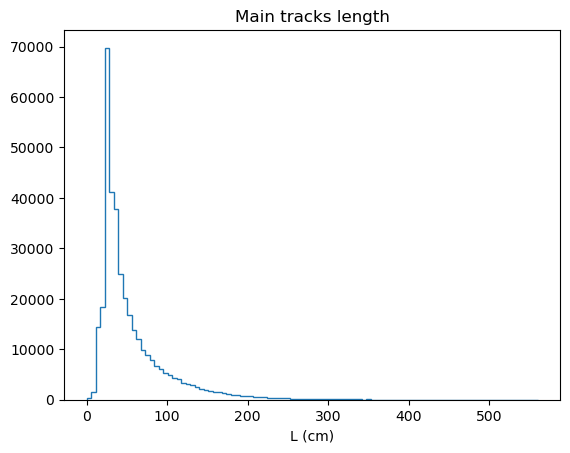

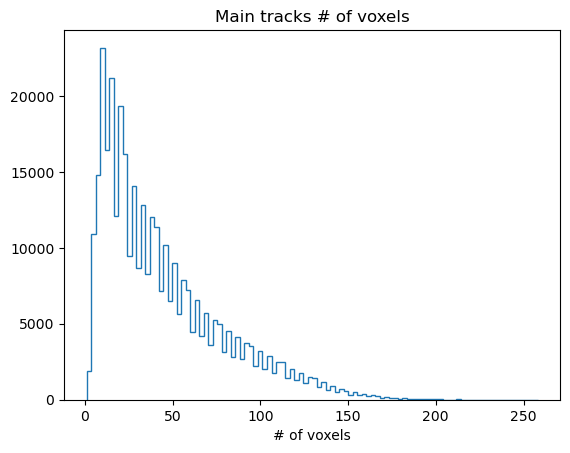

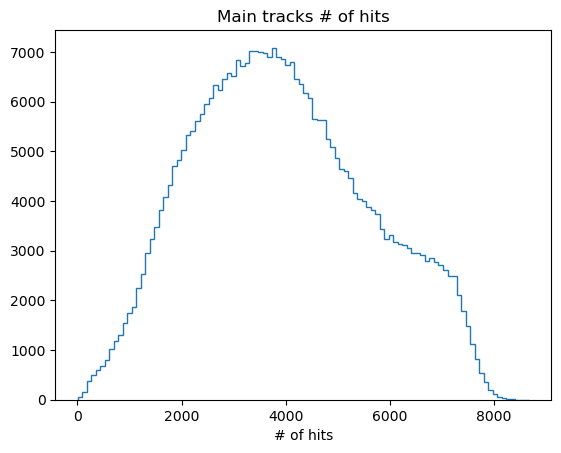

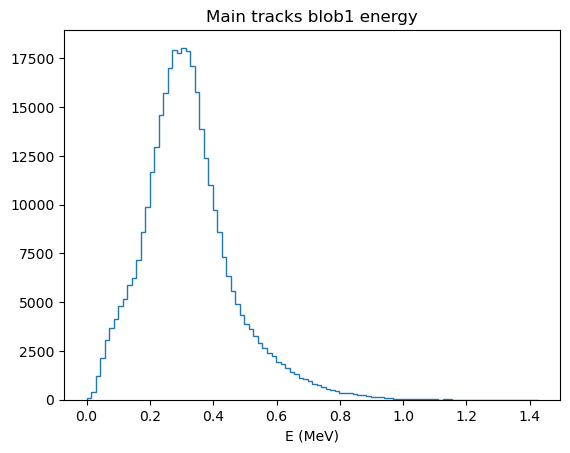

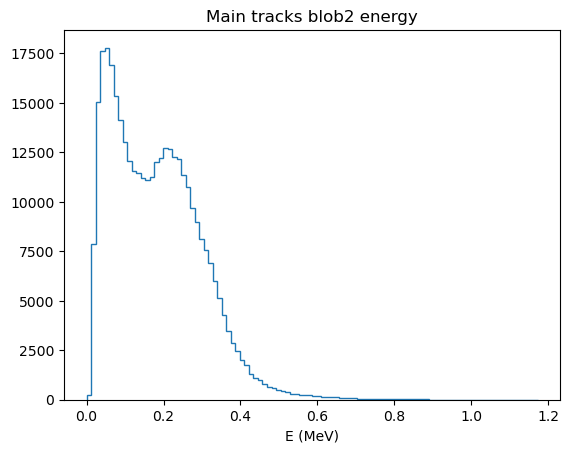

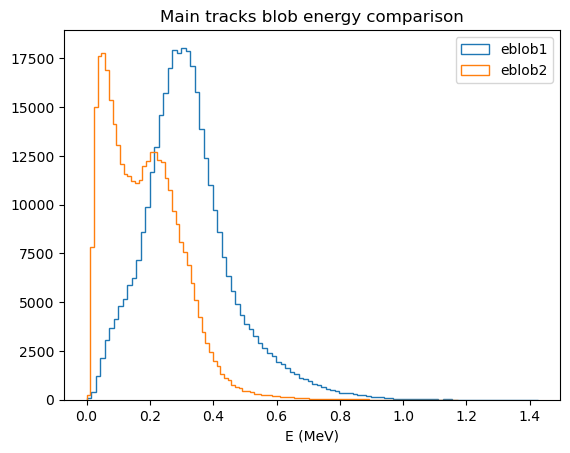

In [39]:
isa_main_trk = isaura_tracks[isaura_tracks.trackID == 0]

plt.hist(isa_main_trk.energy, 100, histtype='step')
plt.xlabel('E (MeV)')
plt.title('Main tracks energy')
plt.show()

plt.hist(isa_main_trk.length, 100, histtype='step')
plt.xlabel('L (cm)')
plt.title('Main tracks length')
plt.show()

plt.hist(isa_main_trk.numb_of_voxels, 100, histtype='step')
plt.xlabel('# of voxels')
plt.title('Main tracks # of voxels')
plt.show()

plt.hist(isa_main_trk.numb_of_hits, 100, histtype='step')
plt.xlabel('# of hits')
plt.title('Main tracks # of hits')
plt.show()

plt.hist(isa_main_trk.eblob1, 100, histtype='step')
plt.xlabel('E (MeV)')
plt.title('Main tracks blob1 energy')
plt.show()

plt.hist(isa_main_trk.eblob2, 100, histtype='step')
plt.xlabel('E (MeV)')
plt.title('Main tracks blob2 energy')
plt.show()

plt.hist(isa_main_trk.eblob1, 100, histtype='step', label = 'eblob1')
plt.hist(isa_main_trk.eblob2, 100, histtype='step', label = 'eblob2')
plt.xlabel('E (MeV)')
plt.title('Main tracks blob energy comparison')
plt.legend()
plt.show()

## MC isaura analysis

In [2]:
mc_path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/prod/*/nexus_compr/*.h5'

In [3]:
files = sorted(glob.glob(mc_path), key = lambda x: (x.split('/')[-3], int(x.split('_')[-2])))
f = files[1]

In [4]:
f_tr = f.replace('nexus_compr/nexus', 'nexus_compr/tracks/nexus').replace('208Tl.h5', 'tracks_trueinfo.h5')

In [5]:
def ene_fid_cuts(hits, e_cut = (1.4, 1.8), fid_R = 450, fid_z = (20, 1180)):
    inf_e, sup_e = e_cut
    inf_z, sup_z = fid_z
    hits['R'] = np.sqrt(hits.x**2 + hits.y**2)
    mask_r = hits.groupby('event_id').apply(lambda x: False if (x.R > fid_R).any() else True)
    mask_z = hits.groupby('event_id').apply(lambda x: False if (x.z > sup_z).any() or (x.z < inf_z).any() else True)
    mask_e = hits.groupby('event_id').apply(lambda x: False if (x.energy.sum() > sup_e).any() or (x.energy.sum() < inf_e).any() else True)
    mask = (mask_r & mask_z & mask_e)
    hits = hits[hits['event_id'].isin(mask.loc[mask].reset_index()['event_id'])]
    return hits

label_evs = lambda particles: particles.rename(columns = {'event_id':'event'}).groupby('event').apply(lambda x: 1 if np.isin('e+', x.particle_name) else 0).rename('label')

In [6]:
def label_events_df(f, label):
    sig = sum(label)
    bkg = len(label) - sig
    port = f.split('/')[-3]
    nfil = int(f.split('/')[-1].split('_')[-2])

    event_label = pd.DataFrame([[sig, bkg, port, nfil]], columns = ['sig', 'bkg', 'port', 'nfil'])
    return event_label


In [7]:
def create_fom(tracks, eblob2_range = np.arange(0, 0.6, 0.02)):
    tracks_ed = tracks.copy()
    for eblob2 in eblob2_range:
        tracks_ed[f'eblob2_{eblob2}'] = (tracks_ed.eblob2 > eblob2)
    return tracks_ed

In [8]:
def track_fom(f, e_cut = (1.4, 1.8), fid_R = 450, fid_z = (20, 1180), eblob2_range = np.arange(0, 0.6, 0.02)):
    hits   = load_dst(f, 'MC', 'hits')
    part   = load_dst(f, 'MC', 'particles')
    f_tr = f.replace('nexus_compr/nexus', 'nexus_compr/tracks/nexus').replace('208Tl.h5', 'tracks_trueinfo.h5')
    tracks = pd.read_hdf(f_tr, 'Tracks')

    #selection cuts and label events
    hits = ene_fid_cuts(hits, e_cut = e_cut, fid_R = fid_R, fid_z = fid_z)
    label = label_evs(part)

    tracks = tracks.merge(label, on ='event')
    tracks = tracks[np.isin(tracks.event, hits.event_id.unique()) & (tracks.numb_of_tracks == 1) & (tracks.ovlp_blob_energy <= 0)]


    ev_label = label_events_df(f, label)
    tracks['port'] = f.split('/')[-3]
    fom_tracks = create_fom(tracks, eblob2_range = eblob2_range)
    return ev_label, fom_tracks

In [9]:
save_path_fom = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/LPR/208Tl/fom_208Tl.h5'

# for f in files:
#     ev_label, fom_tracks = track_fom(f, eblob2_range=np.arange(0, 1, 0.02))
#     ev_label.to_hdf(save_path_fom, key = 'label_info', append = True) 
#     fom_tracks.to_hdf(save_path_fom, key = 'fom', append = True)


In [17]:
fom = pd.read_hdf(save_path_fom, 'fom')

In [19]:
sig = fom.label.sum()
bkg = len(fom) - sig

sig_eff = fom[fom.label == 1].sum().iloc[37:] / sig
bkg_eff = fom[fom.label == 0].sum().iloc[37:] / bkg
fom_values = sig_eff / bkg_eff.apply(lambda x: np.sqrt(x))

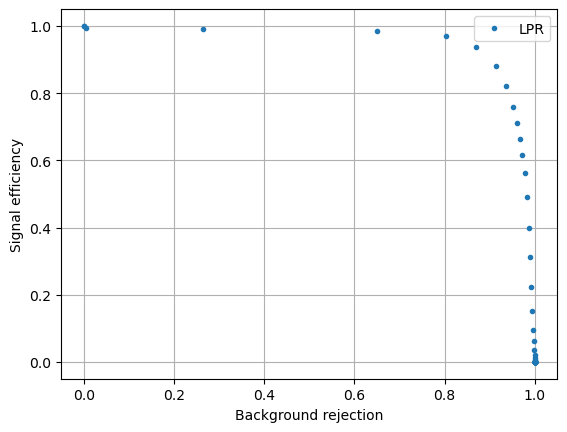

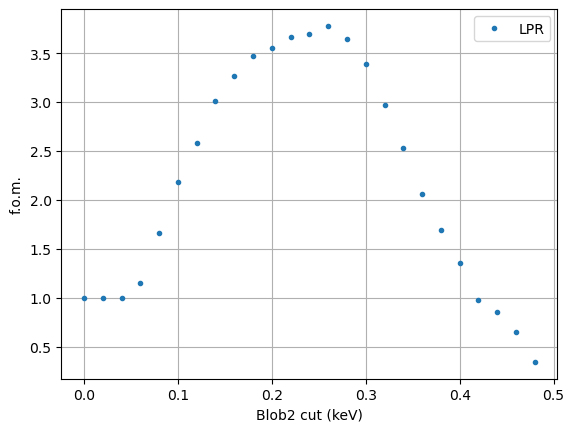

In [30]:
plt.plot(1 - bkg_eff, sig_eff, '.', label = 'LPR')
plt.xlabel('Background rejection')
plt.ylabel('Signal efficiency')
plt.xticks(np.arange(0, 1.2, 0.2))
plt.grid()
plt.legend()
plt.show()

plt.plot(np.arange(0, 1, 0.02), fom_values, '.', label = 'LPR')
plt.xlabel('Blob2 cut (keV)')
plt.ylabel('f.o.m.')
plt.legend()
plt.grid()